### Company Reports - Text Analysis - ClimateBERT

#### Import Packages 

In [1]:
import fitz  # PyMuPDF   

In [2]:
import pandas as pd

In [3]:
import os

In [4]:
import torch

In [5]:
from transformers import AutoTokenizer, AutoModel 

In [6]:
import pickle

In [7]:
import nltk

In [8]:
from nltk.tokenize import sent_tokenize

In [9]:
import numpy as np 

In [10]:
import itertools

#### Load the dataframes 

In [11]:
### import the reports text 

In [12]:
with open('text_dataframe_water_sbert.pkl', 'rb') as file:
    text_dataframe_water = pickle.load(file)

In [13]:
text_dataframe_water['Company Name'].value_counts() 

Company Name
ACCIONA S.A                            4
Kirin Holdings Co Ltd                  4
NSK Ltd                                4
PTT Global Chemical                    4
Tech Mahindra                          4
ÇİMSA ÇİMENTO SANAYİ VE TİCARET A.Ş    4
CLP Holdings Limited                   4
Fanuc Corporation                      4
Pyxus International, Inc               4
RWE AG                                 4
Sasol Limited                          4
Trelleborg AB                          4
Asahi Kasei Corporation                4
Hormel Foods                           4
K + S AG                               4
Kroger                                 4
MRC Global Inc                         4
Union Pacific Corporation              4
Ansell                                 4
Form Factor Inc                        4
Halliburton Company                    4
Life Healthcare Group Holdings Ltd     4
Micron Technology, Inc                 4
Teck Resources Limited                 4
Nam

In [14]:
with open('text_dataframe_water_exploded_sbert.pkl', 'rb') as file:
    text_dataframe_water_exploded = pickle.load(file) 

In [15]:
### import the dataframes'text 
#open the text file
framework_text = pd.read_excel('C:\\Users\\nourd\\OneDrive\\Documents\\Master of Research\\Thesis - Master\\NLP Modelling\\Water Standards Text.xlsx', engine='openpyxl')

In [16]:
###tokenize the text column into sentences 
framework_text['Sentences'] = framework_text['Text'].apply(sent_tokenize)

In [17]:
# no leading spaces in the column names
framework_text.columns = framework_text.columns.str.strip()

In [18]:
# reorder the dataframe columns 
framework_text = framework_text[['Framework', 'Category', 'Text','Sentences']] 

In [19]:
## in the dataframe 'framework_text' we are interested in the columns 'Category','Framework','Sentences'
reports_sentences = framework_text.groupby(['Framework','Category'])['Sentences'].apply(list).to_dict()

In [20]:
framework_dict = {}
grouped = framework_text.groupby(['Framework', 'Category'])['Sentences']

for (framework, category), sentences in grouped:
    if framework not in framework_dict:
        framework_dict[framework] = {}
    framework_dict[framework][category] = list(sentences) 

In [21]:
# prepare company reports 
company_reports = list(itertools.chain.from_iterable(text_dataframe_water['sentences']))

#### Modelling 

In [22]:
# Load ClimateBERT model and tokenizer
climate_model_name = "Climatebert/distilroberta-base-climate-f"

In [23]:
tokenizer = AutoTokenizer.from_pretrained(climate_model_name)

In [24]:
model = AutoModel.from_pretrained(climate_model_name) 

Some weights of RobertaModel were not initialized from the model checkpoint at Climatebert/distilroberta-base-climate-f and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# choose where to run the model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# moves the model to the chosen device 
model.to(device) 
#sets the model into evaluation mode if not the output will be different everytime you run teh code 
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50500, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (drop

In [26]:
# Mean pooling function
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return (token_embeddings * input_mask_expanded).sum(1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [27]:
def get_climatebert_embeddings(sentences, batch_size=32):
    if isinstance(sentences, str):
        sentences = [sentences]
    elif not isinstance(sentences, list):
        raise TypeError("Input must be a string or a list of strings.")

    # Filter out non-string entries
    sentences = [str(s) for s in sentences if isinstance(s, str) or s is not None]

    if len(sentences) == 0:
        raise ValueError("No valid sentences provided for embedding.")

    all_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)

        with torch.no_grad():
            model_output = model(**encoded_input)

        embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

In [28]:
import itertools 

In [29]:
company_reports = list(itertools.chain.from_iterable(text_dataframe_water['sentences']))

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
# Step 1: Compute ClimateBERT embeddings for the report sentences
climatebert_report_embeddings = get_climatebert_embeddings(company_reports)

# Step 2: Initialize result containers for ClimateBERT-based similarity scores
climatebert_framework_similarities = {}
climatebert_category_similarities = {}

# Step 3: Loop through frameworks and categories
for framework, categories in framework_dict.items():
    climatebert_framework_cat_scores = []

    for category, rep_sentences in categories.items():
        if not rep_sentences:
            continue

        # Normalize sentence format (flatten nested lists, convert strings to lists)
        if isinstance(rep_sentences, str):
            rep_sentences = [rep_sentences]
        rep_sentences = [s for sublist in rep_sentences for s in (sublist if isinstance(sublist, list) else [sublist])]
        rep_sentences = [s for s in rep_sentences if isinstance(s, str) and s.strip()]

        try:
            climatebert_rep_embeddings = get_climatebert_embeddings(rep_sentences)
        except Exception as e:
            print(f"Encoding failed for Framework '{framework}', Category '{category}' with error: {e}")
            continue

        # Compute cosine similarity between report and representative embeddings
        climatebert_sims = cosine_similarity(climatebert_report_embeddings, climatebert_rep_embeddings)

        # Step 1: Average over representative sentences
        climatebert_avg_sims = climatebert_sims.mean(axis=1)

        # Step 2: Scale similarity scores to 0–100
        min_score = climatebert_avg_sims.min()
        max_score = climatebert_avg_sims.max()
        if max_score > min_score:
            climatebert_scaled_avg_sims = (climatebert_avg_sims - min_score) / (max_score - min_score) * 100
        else:
            climatebert_scaled_avg_sims = np.zeros_like(climatebert_avg_sims)

        # Save per category in framework
        climatebert_framework_cat_scores.append(climatebert_scaled_avg_sims)

        # Also track per category globally
        key = (framework, category)
        if key not in climatebert_category_similarities:
            climatebert_category_similarities[key] = []
        climatebert_category_similarities[key].append(climatebert_scaled_avg_sims)

    # Step 3: Average across categories in this framework
    if climatebert_framework_cat_scores:
        climatebert_framework_scores = np.vstack(climatebert_framework_cat_scores).mean(axis=0)
        climatebert_framework_similarities[framework] = climatebert_framework_scores

In [33]:
climatebert_framework_similarities_df = pd.DataFrame(climatebert_framework_similarities)

In [34]:
climatebert_framework_similarities_df.describe()

,Alliance For Water Stewardship,GRI 303: Water and Effluents 2018,The CEO Water Mandate,WWF's Water Stewardship Ladder
count,30155.000000,30155.000000,30155.000000,30155.000000
mean,88.421349,89.370880,87.221375,89.734337
std,8.390333,7.421677,9.068477,7.477378
min,0.000000,0.000000,1.475555,0.000000
25%,86.861240,88.143524,85.747833,88.474251
50%,90.544350,91.281631,89.781357,91.637436
75%,93.054066,93.362457,92.287754,93.818146
max,99.299271,99.414223,98.050606,99.848137


In [35]:
averages_climatebert = {framework : np.mean(scores) for framework,scores in climatebert_framework_similarities.items()}

In [36]:
averages_climatebert

{'Alliance For Water Stewardship': np.float32(88.42135),
 'GRI 303: Water and Effluents 2018': np.float32(89.37088),
 'The CEO Water Mandate': np.float32(87.221375),
 "WWF's Water Stewardship Ladder": np.float32(89.73434)}

In [37]:
import matplotlib.pyplot as plt

(0.0, 100.0)

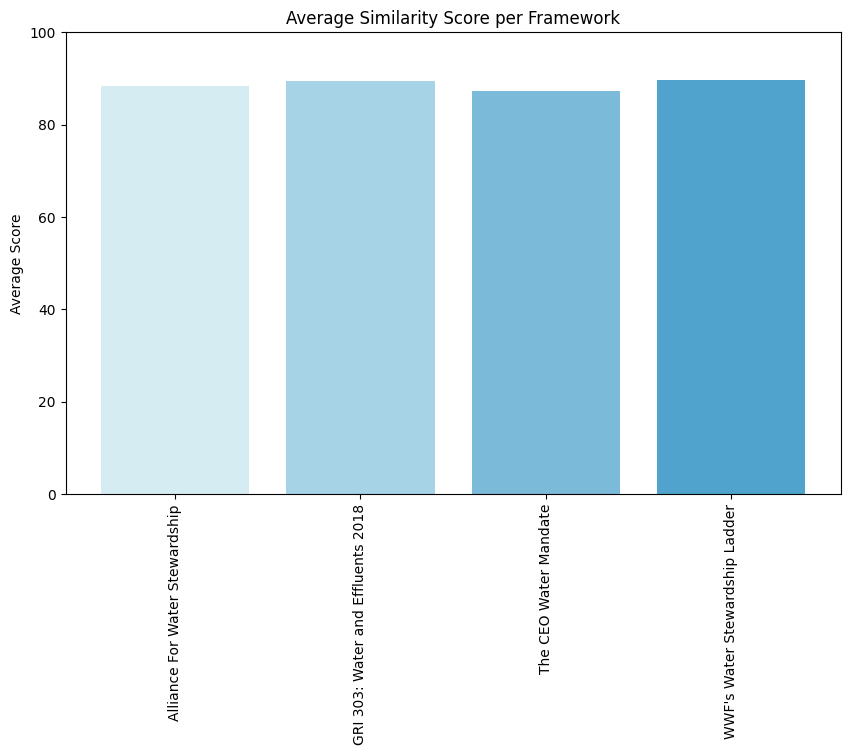

In [38]:
# Plotting the averages
plt.figure(figsize=(10, 6))
frameworks = list(averages_climatebert.keys())
avg_values = list(averages_climatebert.values()) 

bars = plt.bar(frameworks, avg_values, color=['#D6ECF3', '#A7D3E6', '#7BBBD9','#4FA3CC'])
plt.title('Average Similarity Score per Framework')
plt.ylabel('Average Score')
plt.xticks(rotation=90)
plt.ylim(0, 100)

In [39]:
# calculate the average for each category 
averages_categories_climatebert = {category : np.mean(scores) for category,scores in climatebert_category_similarities.items()} 
# sorting values in descending order
averages_categories_ordered_climatebert = dict(sorted(averages_categories_climatebert.items(), key=lambda item: item[1], reverse=True))

In [40]:
from collections import defaultdict

In [41]:
import seaborn as sns

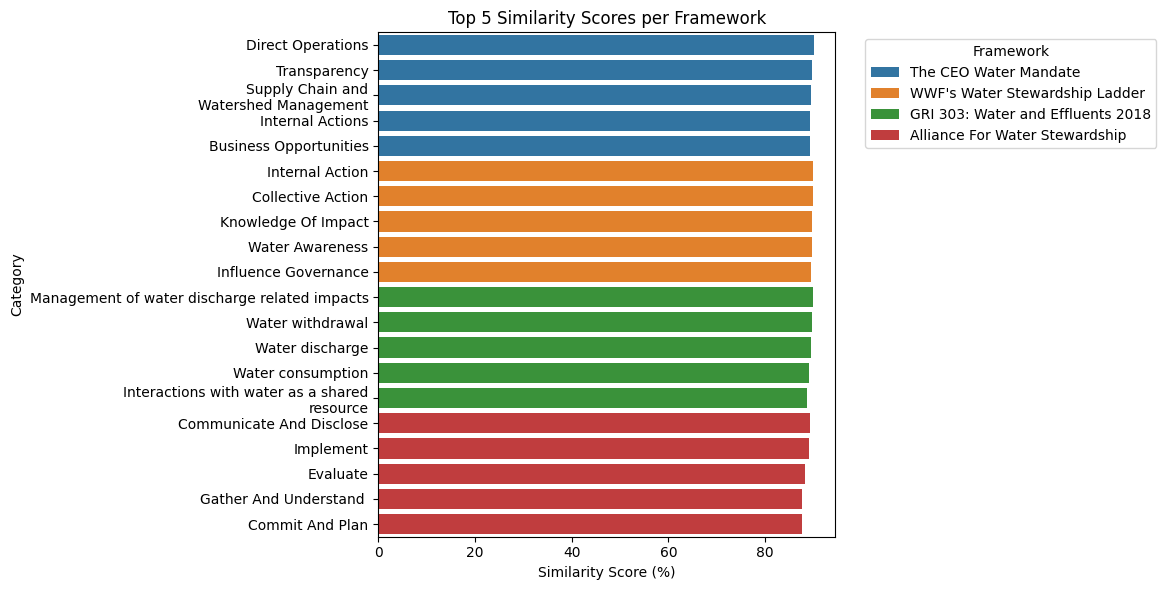

In [42]:
# I want to plot for each framework what are the top 5 categories 
# Group by Framework
grouped_climatebert = defaultdict(list)
for (framework, category), score in averages_categories_ordered_climatebert.items():
    grouped_climatebert[framework].append((category, score))

# For each framework, get top 5 categories
top5_data = []
for framework, cat_scores in grouped_climatebert.items():
    sorted_top5 = sorted(cat_scores, key=lambda x: x[1], reverse=True)[:5]
    for category, score in sorted_top5:
        top5_data.append({'Framework': framework, 'Category': category, 'Score': score})

# Convert to DataFrame
df_top5 = pd.DataFrame(top5_data)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top5, x='Score', y='Category', hue='Framework')
plt.title("Top 5 Similarity Scores per Framework")
plt.xlabel("Similarity Score (%)")
plt.ylabel("Category")
plt.legend(title='Framework', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

I want to plot the least respected categories in each category

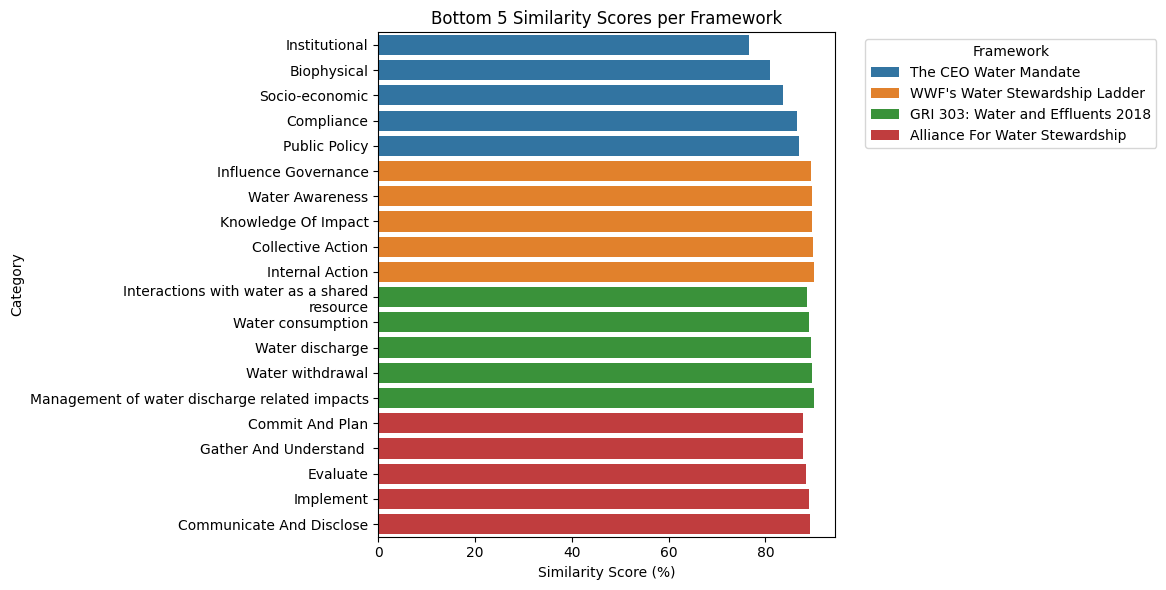

In [43]:
# For each framework, get top 5 categories
bottom5_data = []
for framework, cat_scores in grouped_climatebert.items():
    sorted_bottom5 = sorted(cat_scores, key=lambda x: x[1], reverse=False)[:5]
    for category, score in sorted_bottom5:
        bottom5_data.append({'Framework': framework, 'Category': category, 'Score': score})

# Convert to DataFrame
df_bottom5 = pd.DataFrame(bottom5_data)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_bottom5, x='Score', y='Category', hue='Framework', dodge = False)
plt.title("Bottom 5 Similarity Scores per Framework")
plt.xlabel("Similarity Score (%)")
plt.ylabel("Category")
plt.legend(title='Framework', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### The degree of difference and similarity between common points

In [44]:
def compare_framework_categories_climatebert(df, pair1, pair2):
    """
    Compare average cosine similarity between two (Framework, Category) pairs using ClimateBERT.
    
    Parameters:
    - df: pandas DataFrame with 'Framework', 'Category', and 'Sentences' columns.
    - pair1: tuple -> (framework1, category1)
    - pair2: tuple -> (framework2, category2)

    Returns:
    - Average cosine similarity between the two sets of sentences.
    """
    fw1, cat1 = pair1
    fw2, cat2 = pair2

    # Retrieve sentences
    sents1 = df[(df['Framework'] == fw1) & (df['Category'] == cat1)]['Sentences'].values
    sents2 = df[(df['Framework'] == fw2) & (df['Category'] == cat2)]['Sentences'].values

    if len(sents1) == 0 or len(sents2) == 0:
        print("One or both pairs not found.")
        return None

    # Flatten if needed
    sents1 = sents1[0] if isinstance(sents1[0], list) else [sents1[0]]
    sents2 = sents2[0] if isinstance(sents2[0], list) else [sents2[0]]

    try:
        emb1 = get_climatebert_embeddings(sents1)
        emb2 = get_climatebert_embeddings(sents2)
    except Exception as e:
        print(f"Embedding failed: {e}")
        return None

    # Similarity matrix and average
    sim_matrix = cosine_similarity(emb1, emb2)
    avg_sim = np.mean(sim_matrix)

    print(f"Average cosine similarity between '{fw1} - {cat1}' and '{fw2} - {cat2}': {avg_sim:.4f}")
    return avg_sim

#### Comparison : ('The CEO Water Mandate', 'Performance') , ('Alliance For Water Stewardship', 'Evaluate')

In [45]:
compare_framework_categories_climatebert(
    framework_text,
    ('The CEO Water Mandate', 'Performance'),
    ('Alliance For Water Stewardship', 'Evaluate')
)

Average cosine similarity between 'The CEO Water Mandate - Performance' and 'Alliance For Water Stewardship - Evaluate': 0.9578


np.float32(0.957798)

We can also see that which of the two categories hold **the most similarity with the reports data**.

In [46]:
averages_categories_ordered_climatebert_df = pd.DataFrame([averages_categories_ordered_climatebert]) 

In [47]:
# reshape the dataframe, convert the columns to rows 
averages_categories_ordered_df_melt = averages_categories_ordered_climatebert_df.melt(
    var_name = "Category", 
    value_name = "Similarity" 
)

In [48]:
### filter out for the studied categories 
compared_categories_1 = [('The CEO Water Mandate', 'Performance'),('Alliance For Water Stewardship', 'Evaluate')]
averages_categories_ordered_df_melt[averages_categories_ordered_df_melt["Category"].isin(compared_categories_1)]

,Category,Similarity
22,"(Alliance For Water Stewardship, Evaluate)",88.32354
24,"(The CEO Water Mandate, Performance)",87.98539


#### Comparison : ('The CEO Water Mandate', 'Transparency') and ('Alliance For Water Stewardship', 'Communicate And Disclose')

In [49]:
compare_framework_categories_climatebert(
    framework_text,
    ('The CEO Water Mandate', 'Transparency'),
    ('Alliance For Water Stewardship', 'Communicate And Disclose')
)

Average cosine similarity between 'The CEO Water Mandate - Transparency' and 'Alliance For Water Stewardship - Communicate And Disclose': 0.9672


np.float32(0.9672308)

In [50]:
### filter out for the studied categories 
compared_categories_2 = [('The CEO Water Mandate', 'Transparency'),('Alliance For Water Stewardship', 'Communicate And Disclose')]
averages_categories_ordered_df_melt[averages_categories_ordered_df_melt["Category"].isin(compared_categories_2)] 

,Category,Similarity
6,"(The CEO Water Mandate, Transparency)",89.659103
11,"(Alliance For Water Stewardship, Communicate A...",89.298325


#### Comparison : ('The CEO Water Mandate', 'Policies,Governance, and Targets') and ("WWF's Water Stewardship Ladder", 'Influence Governance')

In [51]:
compare_framework_categories_climatebert(
    framework_text, 
    ('The CEO Water Mandate', 'Policies,Governance, and Targets'),
    ("WWF's Water Stewardship Ladder", 'Influence Governance')
)

Average cosine similarity between 'The CEO Water Mandate - Policies,Governance, and Targets' and 'WWF's Water Stewardship Ladder - Influence Governance': 0.9603


np.float32(0.96032494)

In [52]:
### filter out for the studied categories 
compared_categories_3 = [('The CEO Water Mandate', 'Policies,Governance, and Targets'),("WWF's Water Stewardship Ladder", 'Influence Governance')]
averages_categories_ordered_df_melt[averages_categories_ordered_df_melt["Category"].isin(compared_categories_3)]

,Category,Similarity
9,"(WWF's Water Stewardship Ladder, Influence Gov...",89.473038
21,"(The CEO Water Mandate, Policies,Governance, a...",88.355659


#### Comparison ('The CEO Water Mandate', 'Internal Actions'), ("WWF's Water Stewardship Ladder", 'Internal Action')

In [53]:
compare_framework_categories_climatebert(
    framework_text,
    ('The CEO Water Mandate', 'Internal Actions'),
    ("WWF's Water Stewardship Ladder", 'Internal Action')
)

Average cosine similarity between 'The CEO Water Mandate - Internal Actions' and 'WWF's Water Stewardship Ladder - Internal Action': 0.9633


np.float32(0.9632839)

In [54]:
### filter out for the studied categories 
compared_categories_4 = [('The CEO Water Mandate', 'Internal Actions'),("WWF's Water Stewardship Ladder", 'Internal Action')]
averages_categories_ordered_df_melt[averages_categories_ordered_df_melt["Category"].isin(compared_categories_4)]

,Category,Similarity
1,"(WWF's Water Stewardship Ladder, Internal Action)",89.987999
12,"(The CEO Water Mandate, Internal Actions)",89.276825


### Similarity Analysis in relation to Performance

In [55]:
### prepare framework similarity dataframe 
climatebert_framework_similarities_df = pd.DataFrame(climatebert_framework_similarities)
# rename columns 
rename_dict = {
    'Alliance For Water Stewardship': 'Alliance For Water Stewardship Similarity' , 
    'GRI 303: Water and Effluents 2018' : 'GRI 303: Water and Effluents 2018 Similarity', 
    'The CEO Water Mandate': 'The CEO Water Mandate Similarity' , 
    "WWF's Water Stewardship Ladder" : "WWF's Water Stewardship Ladder Similarity" 
} 
climatebert_framework_similarities_df.rename(columns = rename_dict,inplace = True) 

In [56]:
# reset the index of the dataframe 
text_dataframe_water_exploded_reset = text_dataframe_water_exploded.reset_index()

In [66]:
text_dataframe_water_exploded_reset.head()

,index,Doc ID,Company Name,File Name,Rating,sentences
0,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,reduced the fossil energy consumption by 83% c...
1,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"In order to consolidate this trend, we have re..."
2,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"In 2021, we also reduced the consumption of mu..."
3,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"Regarding waste, 87% of non-hazardous waste wa..."
4,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"Likewise, we consumed 28% of recycled or renew..."


In [57]:
### concat the dataframes 
full_data = pd.concat([text_dataframe_water_exploded_reset,climatebert_framework_similarities_df], axis = 1)

In [58]:
full_data.shape

(30157, 10)

In [59]:
cols = ['Alliance For Water Stewardship Similarity','GRI 303: Water and Effluents 2018 Similarity',
        'The CEO Water Mandate Similarity',"WWF's Water Stewardship Ladder Similarity"] 

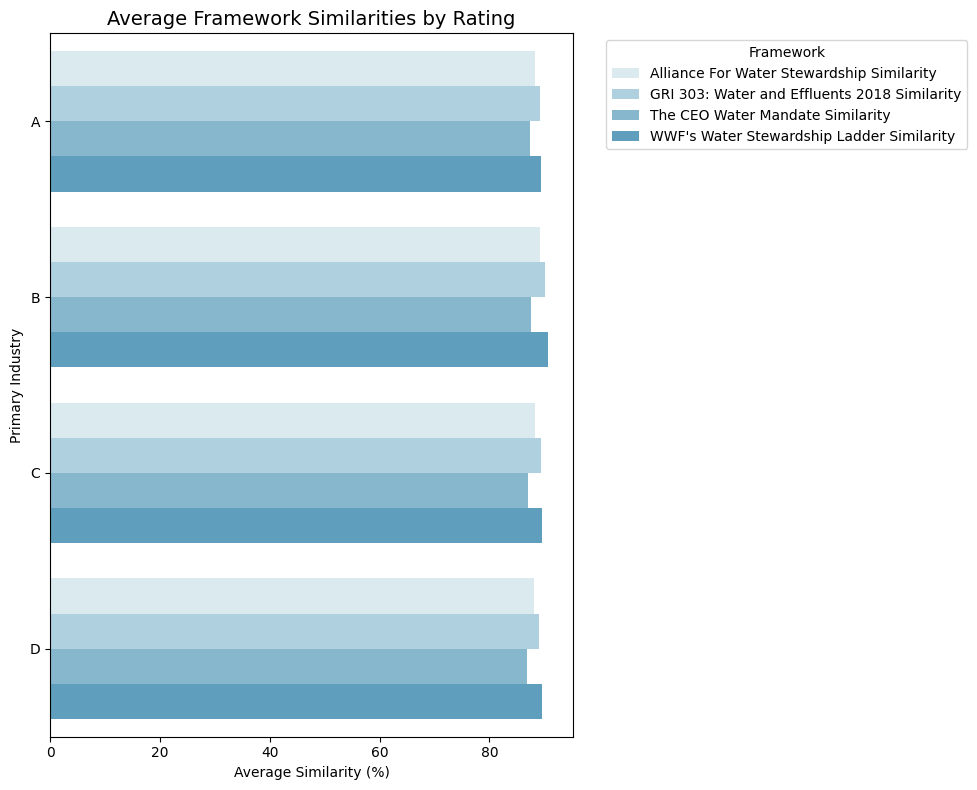

In [60]:
##group the data by Rating 
grouped = full_data.groupby('Rating')[cols].mean() 

## reset index 
grouped.reset_index(inplace = True) 

## plot the ratings' similarity  
#convert to long format for visualizations
long_industry_df = grouped.melt(
              id_vars = 'Rating', 
              var_name='Framework', 
              value_name='Similarity'

)

# Plot
plt.figure(figsize=(10, 8))
custom_palette = ['#D6ECF3', '#A7D3E6', '#7BBBD9','#4FA3CC']

sns.set_palette(custom_palette)

g = sns.barplot(
    data=long_industry_df,
    y='Rating',
    x='Similarity',
    hue='Framework'
)

# Customize legend
plt.title('Average Framework Similarities by Rating', fontsize=14)
plt.xlabel('Average Similarity (%)')
plt.ylabel('Primary Industry')

# Move legend outside
plt.legend(title='Framework', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [61]:
import re

In [62]:
full_data['year'] = full_data['File Name'].apply(
    
    lambda x: re.search(r"\d{4}", x).group() 

)  

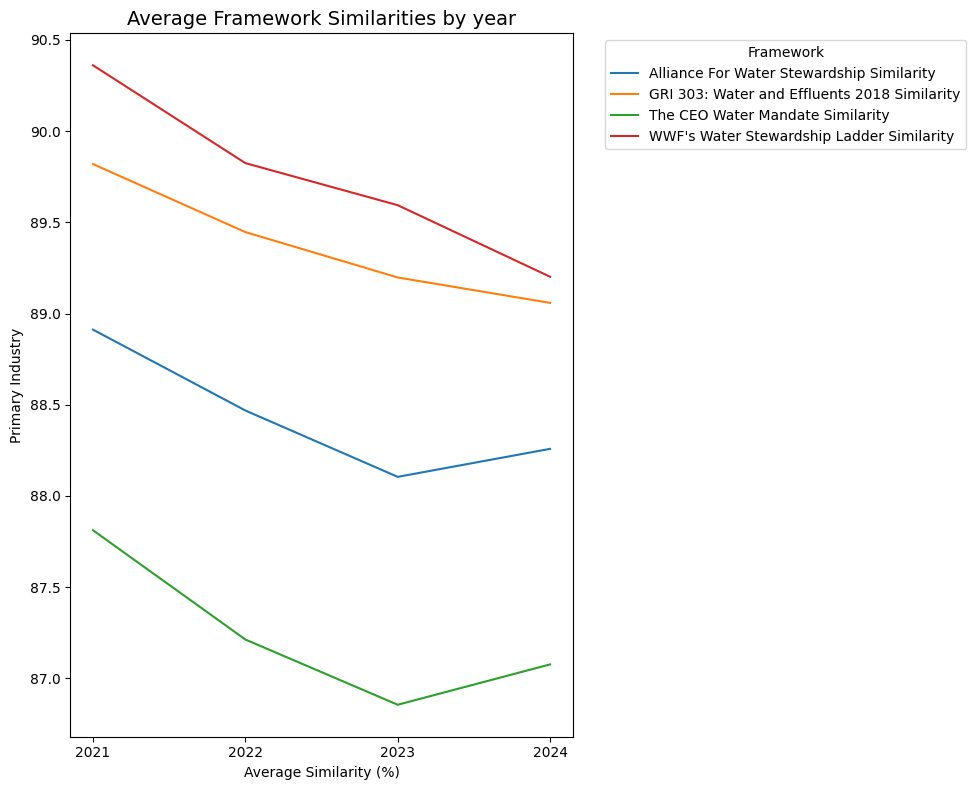

In [63]:
grouped_2 = full_data.groupby('year')[cols].mean() 

## reset index 
grouped_2.reset_index(inplace = True) 

## plot the ratings' similarity  
#convert to long format for visualizations

long_industry_df_2 = grouped_2.melt(
              id_vars = 'year', 
              var_name='Framework', 
              value_name='Similarity'

)

# Plot
plt.figure(figsize=(10, 8))
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

sns.set_palette(palette)

g = sns.lineplot(
    data=long_industry_df_2,
    x='year',
    y='Similarity',
    hue='Framework'
)

# Customize legend
plt.title('Average Framework Similarities by year', fontsize=14)
plt.xlabel('Average Similarity (%)')
plt.ylabel('Primary Industry')

# Move legend outside
plt.legend(title='Framework', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [65]:
full_data.head() 

,index,Doc ID,Company Name,File Name,Rating,sentences,Alliance For Water Stewardship Similarity,GRI 303: Water and Effluents 2018 Similarity,The CEO Water Mandate Similarity,WWF's Water Stewardship Ladder Similarity,year
0,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,reduced the fossil energy consumption by 83% c...,84.930984,88.586838,84.275940,88.953499,2021
1,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"In order to consolidate this trend, we have re...",91.275612,89.960892,92.204689,90.602364,2021
2,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"In 2021, we also reduced the consumption of mu...",88.444092,91.093399,87.783363,89.975945,2021
3,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"Regarding waste, 87% of non-hazardous waste wa...",91.098000,91.457558,90.003647,89.998062,2021
4,0,1,ACCIONA S.A,ACCIONA S.A_2021.pdf,A,"Likewise, we consumed 28% of recycled or renew...",87.745346,90.833572,88.297966,90.628059,2021


### Model Evaluation

In [64]:
climatebert_framework_similarities_df = pd.DataFrame(climatebert_framework_similarities)
overall_summary = pd.Series(climatebert_framework_similarities_df.values.flatten().astype(float)).describe()
print(overall_summary)

count    120620.000000
mean         88.686986
std           8.176289
min           0.000000
25%          87.275257
50%          90.833588
75%          93.175993
max          99.848137
dtype: float64


### Save the essential dataframes

In [64]:
import pickle

In [65]:
# save framework_similarities as pickle
with open('framework_similarities_climatebert.pkl', 'wb') as f:
    pickle.dump(climatebert_framework_similarities, f)

In [66]:
# save category_similarities as pickle
with open('category_similarities_climatebert.pkl', 'wb') as f:
    pickle.dump(climatebert_category_similarities, f)

The high value of the similarity might be attributed to the inclusion of only water related text. 